# Iterative Methods for solving Laplace Equation

In this notebook, we will learn how to solve the Laplace's equation with iteractive methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, njit, prange, set_num_threads

## Mesh Generation

Before we start solving the Laplace's euqtion, we need to generate the mesh first.

In [2]:
def generate_mesh(nx, ny, buff=1, 
                  xmin=0.0, xmax=1.0, ymin=0.0, ymax=1.0):
    """
    Generate 2D mesh grids for solving Laplace equation.

    Parameters
    ----------
    nx : int
        Number of grid points in x direction.
    ny : int
        Number of grid points in y direction.
    buff : int
        Number of ghost cells around the domain.
    xmin : float
        Minimum value of x.
    xmax : float
        Maximum value of x.
    ymin : float
        Minimum value of y.
    ymax : float
        Maximum value of y.

    Returns
    -------
    u : 2D numpy array
        Initial guess. 
        
    x : 2D numpy array
        Mesh grid for x.
    y : 2D numpy array
        Mesh grid for y.

    dx : float
        Grid spacing in x.
    dy : float
        Grid spacing in y.
        
    """
    u = np.zeros((nx+2*buff, ny+2*buff))
    x = np.linspace(xmin, xmax, nx+2*buff)
    y = np.linspace(ymin, ymax, ny+2*buff)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    return u, x, y, dx, dy
   

    
    

## Jacobi method

Recall the finite difference equations for the Laplace's equation, we have

$$
u_{i,j}^{k+1} = \frac{1}{4}(u_{i-1,j}^k + u_{i,j-1}^k + u_{i+1,j}^k + u_{i,j+1}^k)
$$


### Exercise: Jacobi method

* A unit square with $N \times N$ grids
* Need one layer of ghost cells for boundary conditions
* Boundary Conditions: 1 on the top BC; others are 0 
* Once we have the mesh, implment the jacobi method by
1. Write a function called `jacobi` to implment one Jacobi iteration
2. Write a function called `update_bc` to update the boundary conditions.
3. Write a function called `relax` to iterate the matrix unitl the error matches a tolerance (loop through $k$). 
* Error can be defined by $\sqrt{\sum (u_{\rm ij}^{k+1}- u_{\rm ij}^{k})^2}/N_{\rm cells}$
* The `jacobi` function need to be acclerated by `numba`
* For debugging, you could start from a bigger tolerance first. 
* The your `relax` function with $32\times 32$, $64 \times 64$, and $128 \times 128$ grids.
* Plot errors vs. #iterations, to see how it converges. 

In [27]:
# TODO
@njit(parallel=True)
def jacobi(u, uold, nx, ny):
    for j in prange(1, ny-1):
        for i in prange(1, nx-1):
            #print(i,j)
            u[i,j] = 0.25*(uold[i-1,j] + uold[i+1,j] + uold[i,j-1] + uold[i,j+1])
    return u

@njit(parallel=True)
def gauss(u, uold, nx, ny):
    for j in prange(1, ny-1):
        for i in prange(1, nx-1):
            #print(i,j)
            u[i,j] = 0.25*(u[i-1,j] + u[i+1,j] + uold[i,j-1] + uold[i,j+1])
    return u

@njit(parallel=True)
def gauss_over(u, uold, nx, ny,w=1.3):
    u=gauss(u,uold,nx,ny)
    u=(1-w)*uold+w*u
    return u

def update_bc(u):
    u[0,:] = 0.0 # left boundary
    u[-1,:] = 0.0 # right boundary
    u[:,0] = 1.0 # bottom boundary
    u[:,-1] = 1.0 # top boundary
    return u

def relax(u,method, tolerance, maxiter=1e6):
    """
    Relax the solution using Jacobi method.

    Parameters
    ----------
    u : 2D numpy array
        Initial guess.
    tolerance : float
        Tolerance for convergence.
    maxiter : int
        Maximum number of iterations.
    """
    nx, ny = u.shape # inculde ghost cells
    u = update_bc(u)

    errors = np.zeros(maxiter)
    iterations = np.zeros(maxiter)
    
    if method=='jacobi':
        for n in range(maxiter):
            #print(n, nx, ny)
            uold = u.copy()
            u = jacobi(u, uold, nx, ny)
            err = np.linalg.norm(u - uold)
            errors[n] = err
            iterations[n] = n
            if err < tolerance:
                break
            
    elif method=='gauss':
        for n in range(maxiter):
            #print(n, nx, ny)
            uold = u.copy()
            u = gauss(u, uold, nx, ny)
            err = np.linalg.norm(u - uold)
            errors[n] = err
            iterations[n] = n
            if err < tolerance:
                break
            
    elif method=='gauss_over':
        for n in range(maxiter):
            #print(n, nx, ny)
            uold = u.copy()
            u = gauss_over(u, uold, nx, ny)
            err = np.linalg.norm(u - uold)
            errors[n] = err
            iterations[n] = n
            if err < tolerance:
                break

    
    return u, iterations, errors


In [28]:
u,x,y,dx,dy = generate_mesh(32,32)
u, itt32, err32 = relax(u,'jacobi', tolerance=1e-6, maxiter=1_000_000)

In [29]:
u,x,y,dx,dy = generate_mesh(64,64)
u, itt64, err64 = relax(u,'jacobi', tolerance=1e-6, maxiter=1_000_000)

In [30]:
u,x,y,dx,dy = generate_mesh(128,128)
u, itt128, err128 = relax(u,'jacobi', tolerance=1e-6, maxiter=1_000_000)

Text(0, 0.5, 'Error')

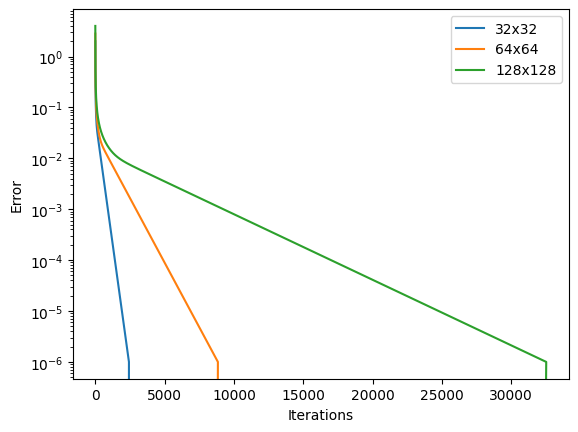

In [7]:
plt.plot(itt32, err32, label="32x32")
plt.plot(itt64, err64, label= "64x64")
plt.plot(itt128, err128, label="128x128")
plt.yscale('log')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Error')

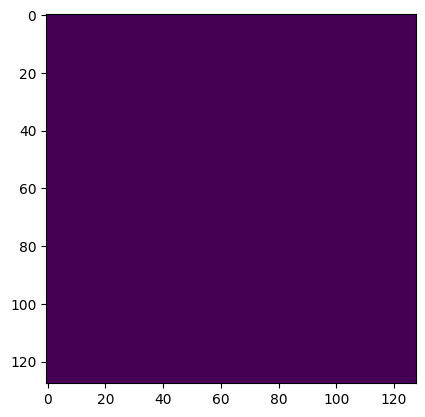

In [31]:
plt.imshow(u[1:-1,1:-1], cmap='viridis')

# Gauss-Seidel Method

* Gauss-Seidel meothd remedies this by using each new component of solution as soon as it has been computed. 

$$
{\rm Gauss-Seidel: } u_{i,j}^{k+1} = \frac{1}{4}(u_{i-1,j}^{k+1} + u_{i,j-1}^{k+1} + u_{i+1,j}^k + u_{i,j+1}^k)
$$


* The Gauss-Seidel method averages solution values at four surrounding grid points, but always use new component values as soon as they become available, rather than waiting until current iteration has been completed.
* No need a copy of `u`.
* Gauss-Seidel method does not always converge, but it is guaranteed to converge under conditions that are often satisfied in practice.
* Although Gauss-Seidel converges more rapidly than the Jacobi method, it is often still too slow to be practical.

### Exercise: Gauss-Seidel Method

* Modify your `relax` function to support the Gauss-Seidel Method
* write a function `gauss_seidel()` to implement one Gauss-Seidel iteration.
* The `gauss_seidel()` function need to be accelerated by numba.
* Compare the number of iterations (and the computing time) between Jacobi method and Gauss-Seidel method. 

In [9]:
# TODO:
u,x,y,dx,dy = generate_mesh(32,32)
u, itt32, err32 = relax(u,'gauss', tolerance=1e-6, maxiter=1_000_000)

In [10]:
u,x,y,dx,dy = generate_mesh(64,64)
u, itt64, err64 = relax(u,'gauss', tolerance=1e-6, maxiter=1_000_000)

In [11]:
u,x,y,dx,dy = generate_mesh(128,128)
u, itt128, err128= relax(u,'gauss', tolerance=1e-6, maxiter=1_000_000)

Text(0, 0.5, 'Error')

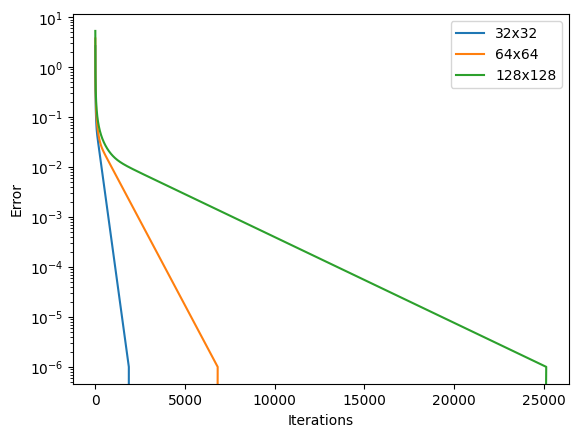

In [12]:
plt.plot(itt32, err32, label="32x32")
plt.plot(itt64, err64, label= "64x64")
plt.plot(itt128, err128, label="128x128")
plt.yscale('log')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Error')

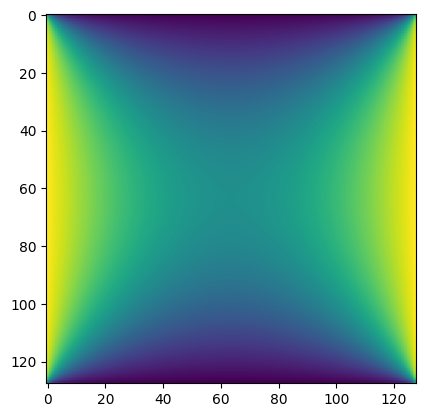

In [13]:
plt.imshow(u[1:-1,1:-1], cmap='viridis')

# Successive Over-Relaxation (SOR)

* Convergence rate of Gauss-Seidel can be accelerated by successive over-relaxation (SOR) method. 
* Starting with $x^k$ first, compute next iterate that would be given by Gauss-Seidel $x_{GS}^{k+1}$, then instead take next iterate to be

$$
x^{k+1} = x^k + \omega(x_{GS}^{k+1} - x^k) = (1-\omega)x^k + \omega x_{GS}^{k+1}
$$

*  Which is weighted average of current iterate and next GS iterate
* $w$ is a fixed relaxation parameter chosen to accelerate convergence
* $w > 1$ gives over-relaxation
* $w<1$ gives under-relaxation
* $w=1$ gibes Gauss-Seidel meothd
* Method diverges unless $0 < w < 2$, but choosing optimal $w$ is difficult in general. 

### Exercise: Successive Over-Relaxation

* Consider $64 \times 64$ first for developing the solver
* Write a function called `successive_over_relax()` to implement one SOR iteration.
* Modify the `relax()` to support the SOR method.
* The `successive_over_relax()` function need to be accelerated by `numba`.
* Compare the number of iterations (and the computing time) with all other methods. 

Text(0, 0.5, 'Error')

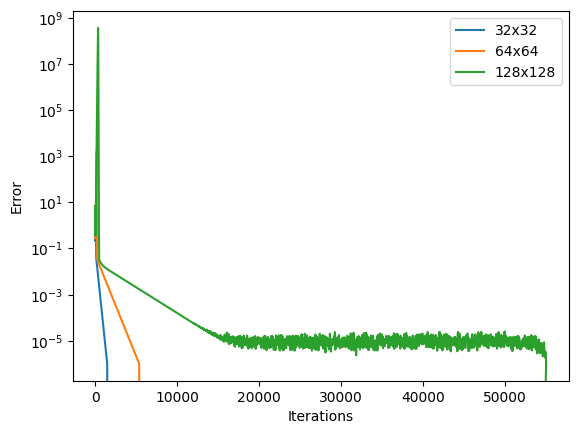

In [24]:
#TODO
u,x,y,dx,dy = generate_mesh(32,32)
u, itt32, err32 = relax(u,'gauss_over', tolerance=1e-6, maxiter=1_000_000)

u,x,y,dx,dy = generate_mesh(64,64)
u, itt64, err64 = relax(u,'gauss_over', tolerance=1e-6, maxiter=1_000_000)

u,x,y,dx,dy = generate_mesh(128,128)
u, itt128, err128= relax(u,'gauss_over', tolerance=1e-6, maxiter=1_000_000)

plt.plot(itt32, err32, label="32x32")
plt.plot(itt64, err64, label= "64x64")
plt.plot(itt128, err128, label="128x128")
plt.yscale('log')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Error')


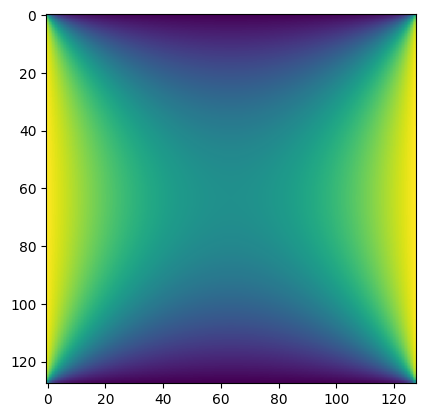

In [25]:
plt.imshow(u[1:-1,1:-1], cmap='viridis')

## Extending to Poisson's equation

* Extend your solver for solving Poisson's eq. 
* Question: How to modify the Gauss-Seidel's method?
* Consider a $128\times 128$ grids in a domain ($-1<x<1$; $-1<y<1$)
* Assume $\rho(r)= e^{-10r}$, 
* Assume $u=0$ on all four boundaries.
* Solve for the potential "$u$".

In [48]:
# TODO
def generate_rho(nx,ny,buff,xmin=-1,xmax=1,ymin=-1,ymax=1):
    # TODO:
    xx = np.linspace(xmin, xmax, nx+2*buff)
    yy = np.linspace(ymin, ymax, ny+2*buff)
    x0=np.zeros(nx+2*buff)
    y0=np.zeros(ny+2*buff)
    rho=np.array(x0,y0)
    
    for i in np.arange(nx):
        x=xx[i]
        for j in np.arange(ny):
            y=yy[j]
            r=np.sqrt(x**2+y**2)
            rho[i,j]=np.exp(-10*r)
        
    return rho

@njit(parallel=True)
def jacobi(u, uold, rho, nx, ny,h):
    for j in prange(1, ny-1):
        for i in prange(1, nx-1):
            #print(i,j)
            u[i,j] = 0.25*(uold[i-1,j] + uold[i+1,j] + uold[i,j-1] + uold[i,j+1]-h**2*rho[i,j])
    return u

@njit(parallel=True)
def gauss(u, uold, nx, ny):
    for j in prange(1, ny-1):
        for i in prange(1, nx-1):
            #print(i,j)
            u[i,j] = 0.25*(u[i-1,j] + u[i+1,j] + uold[i,j-1] + uold[i,j+1])
    return u

@njit(parallel=True)
def gauss_over(u, uold, nx, ny,w=1.3):
    u=gauss(u,uold,nx,ny)
    u=(1-w)*uold+w*u
    return u

def update_bc(u):
    u[0,:] = 0.0 # left boundary
    u[-1,:] = 0.0 # right boundary
    u[:,0] = 1.0 # bottom boundary
    u[:,-1] = 1.0 # top boundary
    return u

def relax(u,method,rho=None, tolerance=1e-6, maxiter=1e6):
    """
    Relax the solution using Jacobi method.

    Parameters
    ----------
    u : 2D numpy array
        Initial guess.
    tolerance : float
        Tolerance for convergence.
    maxiter : int
        Maximum number of iterations.
    """
    nx, ny = u.shape # inculde ghost cells
    u = update_bc(u)
    rho = generate_rho(nx,ny,buff=1)

    errors = np.zeros(maxiter)
    iterations = np.zeros(maxiter)
    if method=='jacobi':
        for n in range(maxiter):
            #print(n, nx, ny)
            uold = u.copy()
            u = jacobi(u, uold, rho, nx, ny,h=dx)
            err = np.linalg.norm(u - uold)
            errors[n] = err
            iterations[n] = n
            if err < tolerance:
                break
            
    elif method=='gauss':
        for n in range(maxiter):
            #print(n, nx, ny)
            uold = u.copy()
            u = gauss(u, uold, nx, ny)
            err = np.linalg.norm(u - uold)
            errors[n] = err
            iterations[n] = n
            if err < tolerance:
                break
            
    elif method=='gauss_over':
        for n in range(maxiter):
            #print(n, nx, ny)
            uold = u.copy()
            u = gauss_over(u, uold, nx, ny)
            err = np.linalg.norm(u - uold)
            errors[n] = err
            iterations[n] = n
            if err < tolerance:
                break

    
    return u, iterations, errors

In [49]:
u,x,y,dx,dy = generate_mesh(128,128)
u, itt128, err128 = relax(u,'jacobi', tolerance=1e-6, maxiter=1_000_000)
plt.imshow(u[1:-1,1:-1], cmap='viridis')

TypeError: Cannot construct a dtype from an array

# Multigrids methods

* Write two functions to implement the restriction and prolongation of grids.
* Apply the multigrid methods for solving Laplace/Poisson equation
* Redo the error convergence with multigrid methods

In [ ]:
@njit(parallel=True)
def restriction(u,nx,ny,buff):
    nx2=nx//2
    ny2=ny//2
    u_c=np.zeros((nx2+2*buff,ny*2+2*buff))
    
    for i in prange(1,nx2-1):
        for j in prange(1,ny2-1):
            u_c=0.25*(u[2*i-1,2*j]+u[2*i+1,2*j]+u[2*i,2*j-1]+u[2*i,2*j+1])
            
            





